In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest

In [3]:
PATH = 'data/houseprices/'

In [4]:
df_raw = pd.read_csv(f'{PATH}train.csv')

In [5]:
df = pd.read_csv(f'{PATH}train.csv')

In [6]:
!ls {PATH}

models    tmp       train.csv


In [7]:
# df_test = pd.read_csv(f'{PATH}test.csv')

In [8]:
# display(df.transpose())

## Neural Net ##

In [9]:
cat_vars = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
            'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
            'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
            'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
            'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 
            'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
cont_vars = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 
             'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [10]:
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered()

for v in cont_vars:
    if 'Y' in df[v].values:
        df[v] = df[v].map(lambda x: 1 if (x.lower() == 'Y') else 0)
    df[v] = df[v].astype('float32')

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [11]:
# df.dtypes

In [12]:
df.set_index('Id', inplace=True)

In [13]:
df_sep, y, nas, mapper = proc_df(df, 'SalePrice', do_scale=True)
yl = np.log(y)

In [14]:
# iforest = IsolationForest(max_samples = 100, random_state = 42)
# iforest.fit(df_sep)
# y_noano = pd.DataFrame(iforest.predict(df_sep), columns = ['Top'])
# indices = y_noano[y_noano['Top'] == 1].index.values
# df_sep = df_sep.iloc[indices]
# yl = yl[indices]
# df_sep.reset_index(drop = True, inplace = True)

In [15]:
# len(y_noano[y_noano['Top'] == 1])

In [16]:
def exp_rmse(y_pred, targ):
    return np.sqrt(((y_pred-targ)**2).sum()/len(targ))

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [17]:
train_ratio = 0.80
val_idx = get_cv_idxs(len(df_sep))

In [18]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_sep, yl.astype(np.float32), cat_flds=cat_vars, bs=128)

In [19]:
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [20]:
learn = md.get_learner(emb_szs, len(df_sep.columns)-len(cat_vars),
                   0.4, 1, [200, 100, 50, 25, 12], [0.001, 0.001, 0.001, 0.001, 0.01], y_range=y_range)

In [21]:
for i in range(5):
    learn.fit(1e-2, 3, metrics=[exp_rmse], cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   exp_rmse                
    0      3.776806   0.953422   0.976412  
    1      2.159469   0.365375   0.602457                
    2      1.400452   0.083426   0.288763                
    3      1.014943   0.067907   0.260471                
    4      0.757929   0.055231   0.234974                 
    5      0.590565   0.057282   0.239335                 
    6      0.470629   0.049412   0.222284                 



epoch      trn_loss   val_loss   exp_rmse                 
    0      0.675127   0.390992   0.625292  
    1      0.575602   0.409156   0.63942                  
    2      0.404112   0.045401   0.213017                 
    3      0.302234   0.036612   0.191337                 
    4      0.233901   0.031756   0.178201                 
    5      0.189112   0.026919   0.164047                 
    6      0.158848   0.029389   0.171414                 



epoch      trn_loss   val_loss   exp_rmse                 
    0      0.121539   0.087282   0.295435  
    1      0.112302   0.033197   0.181974                 
    2      0.089748   0.03623    0.190313                  
    3      0.076331   0.027209   0.164574                  
    4      0.069132   0.030103   0.173171                  
    5      0.059202   0.024357   0.15569                   
    6      0.050636   0.026734   0.163248                  



epoch      trn_loss   val_loss   exp_rmse                 
    0      0.189099   0.118462   0.343933  
    1      0.191766   0.1755     0.418881                 
    2      0.140484   0.021954   0.14768                  
    3      0.109986   0.035588   0.188073                 
    4      0.088246   0.030469   0.174412                  
    5      0.071757   0.01932    0.138588                  
    6      0.06092    0.019354   0.138699                  



epoch      trn_loss   val_loss   exp_rmse                 
    0      0.10845    0.022209   0.148522  
    1      0.112901   0.032472   0.179861                 
    2      0.08366    0.044974   0.211755                  
    3      0.072281   0.033226   0.181891                   
    4      0.06076    0.031201   0.176307                  
    5      0.050986   0.02108    0.144857                  
    6      0.04351    0.021035   0.144695                  



In [22]:
learn.fit(2e-3, 4, metrics=[exp_rmse], cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmse                  
    0      0.022714   0.020651   0.143371  
    1      0.021482   0.020656   0.14337                   
    2      0.021216   0.020958   0.144412                   
    3      0.021191   0.020449   0.142679                  



[array([0.02045]), 0.14267904693393102]

In [23]:
learn.fit(1e-3, 6, metrics=[exp_rmse], cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmse                  
    0      0.016569   0.021048   0.144712  
    1      0.018647   0.020921   0.144206                  
    2      0.021655   0.019479   0.139112                   
    3      0.021658   0.020415   0.142481                  
    4      0.020244   0.020072   0.141303                  
    5      0.018621   0.019858   0.140539                  



[array([0.01986]), 0.1405387083619968]

epoch      trn_loss   val_loss                             
    0      7.661172   18.195777 



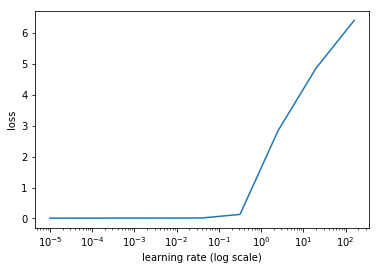

In [24]:
# matplotlib.pyplot.plot(learn.sched.lrs, learn.sched.losses)
learn.lr_find(end_lr=10000)
learn.sched.plot(n_skip=0, n_skip_end=0)
# matplotlib.pyplot.plot((0,5e-4),(6,8))

In [25]:
preds = learn.predict()
actuals = learn.data.val_ds.y
np.sqrt(((preds-actuals)**2).sum()/len(actuals))

0.1409200479128832

## Random Forest ##

In [26]:
((val_df, trn_df), (val_y, trn_y), (val_df_raw, trn_df_raw)) = split_by_idx(val_idx, df_sep, y, df)

In [27]:
train_cats(df)

In [28]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=2)
m.fit(trn_df, trn_y)
m.score(val_df, val_y)

0.8928508483456304

In [29]:
np.sqrt(((np.log(m.predict(val_df))-np.log(val_y))**2).sum()/len(val_y))

0.15296776711333782

## Interpret Random Forest ##

### Confidence based on Tree variance ###

In [30]:
def predict_tree(t):
    return t.predict(val_df)
preds = np.stack(parallel_trees(m, predict_tree))
np.mean(preds[:,0]), np.std(preds[:,0])

(146579.74452380952, 28789.380424169813)

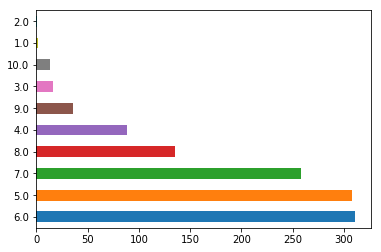

In [31]:
x = val_df_raw.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
trn_df_raw.OverallQual.value_counts().plot.barh()

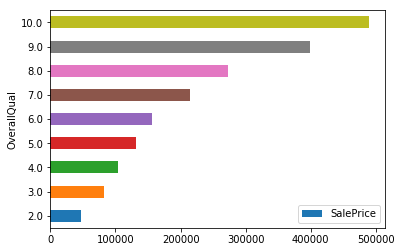

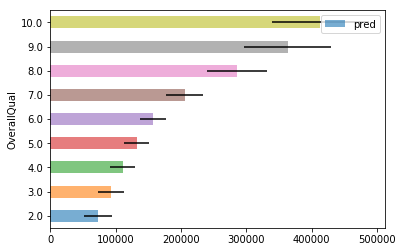

In [32]:
summ = x.groupby('OverallQual', as_index=False).mean()
summ.plot('OverallQual', 'SalePrice', 'barh')
summ.plot('OverallQual', 'pred', 'barh', xerr='pred_std', alpha=0.6)

In [33]:
summ.set_index('OverallQual', inplace=True)
(summ.pred_std/summ.pred).sort_values(ascending=False)

OverallQual
2.0     0.294901
3.0     0.214798
9.0     0.183590
10.0    0.180278
4.0     0.175129
8.0     0.160446
5.0     0.145899
7.0     0.135491
6.0     0.126265
dtype: float64

### Feature Importance ###

In [34]:
fi = rf_feat_importance(m, trn_df)

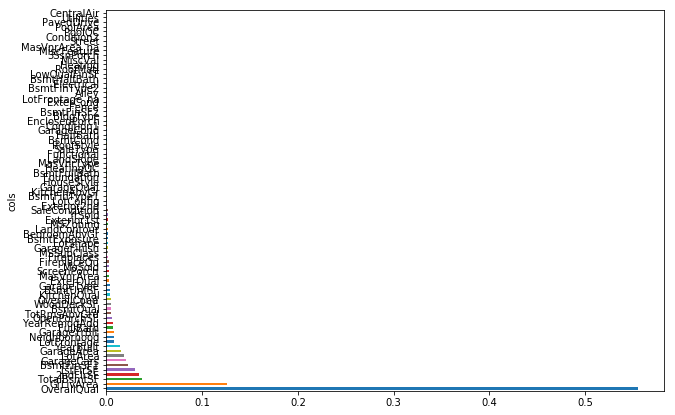

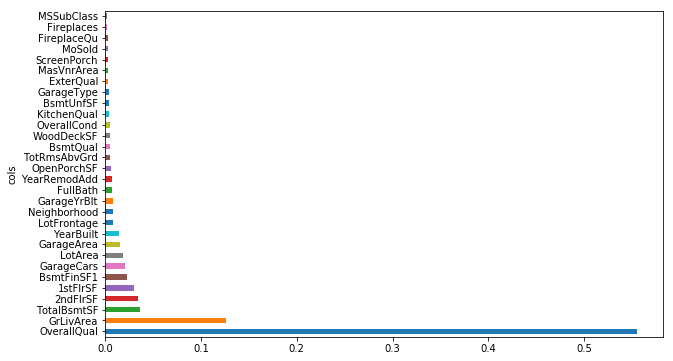

In [35]:
fi.plot('cols', 'imp', 'barh', figsize=(10,7), legend=False)
fi[:30].plot('cols', 'imp', 'barh', figsize=(10,6), legend = False)

In [36]:
trim_cols = {c: i for c, i in zip(fi.cols.values, fi.imp.values) if i > 5e-3}

In [37]:
trim_trn_df = trn_df[list(trim_cols.keys())]
trim_val_df = val_df[list(trim_cols.keys())]

In [38]:
m2 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m2.fit(trim_trn_df, trn_y)
m2.score(trim_val_df, val_y)

0.8914443375441334

In [39]:
trim_trn_df.head()

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,1stFlrSF,BsmtFinSF1,GarageCars,LotArea,GarageArea,YearBuilt,LotFrontage,Neighborhood,GarageYrBlt,FullBath,YearRemodAdd,OpenPorchSF,TotRmsAbvGrd,BsmtQual
Id,,,,,,,,,,,,,,,,,,
1,0.651479,0.370333,-0.459303,1.161852,-0.793434,0.575425,3,-0.207142,0.351000,105,-0.220875,6,90,3,54,0.216503,0.912210,3
2,-0.071836,-0.482512,0.466465,-0.795163,0.257140,1.171992,3,-0.091886,-0.060731,78,0.460320,25,63,3,27,-0.704483,-0.318683,3
3,0.651479,0.515013,-0.313369,1.189351,-0.627826,0.092907,3,0.073480,0.631726,103,-0.084636,6,88,3,53,-0.070361,-0.318683,3
4,0.651479,0.383659,-0.687324,0.937276,-0.521734,-0.499274,4,-0.096897,0.790804,20,-0.447940,7,85,2,21,-0.176048,0.296763,4
5,1.374794,1.299326,0.199680,1.617877,-0.045611,0.463568,4,0.375148,1.698485,102,0.641972,16,87,3,51,0.563760,1.527656,3


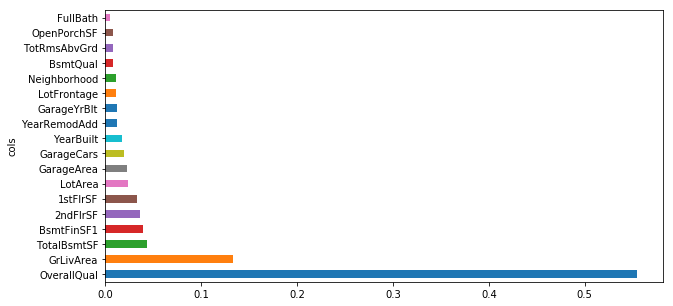

In [40]:
trim_fi = rf_feat_importance(m2, trim_trn_df)
trim_fi.plot('cols', 'imp', 'barh', figsize=(10,5), legend=False)

### One hot encoding (taking some lower cardinality categorical variables and splitting them off into boolean columns) ###

In [41]:
df_sep2, y2, nas = proc_df(df, 'SalePrice', max_n_cat=8)
((val_df2, trn_df2), (val_y2, trn_y2), (val_df_raw2, trn_df_raw2)) = split_by_idx(val_idx, df_sep2, y2, df)
m_oh = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
m_oh.fit(trn_df2, trn_y2)
m_oh.score(val_df2, val_y2)

0.8938326279822342

In [42]:
np.sqrt(((np.log(m_oh.predict(val_df2))-np.log(val_y2))**2).sum()/len(val_y2))

0.1531369767364128

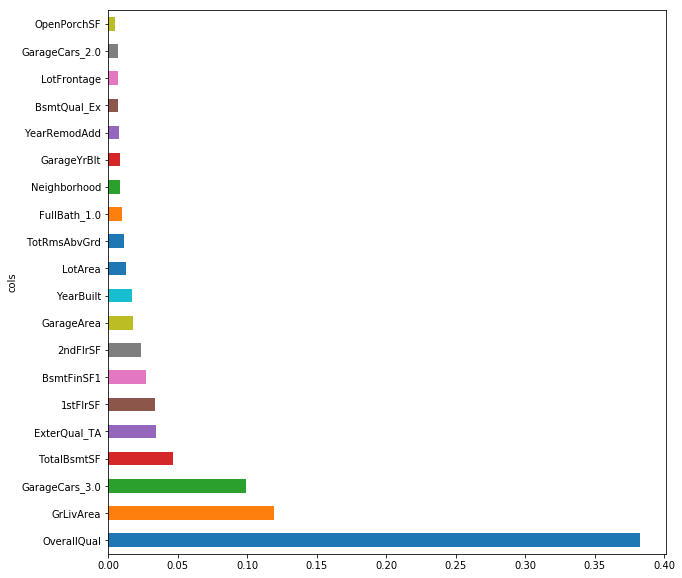

In [43]:
fi2 = rf_feat_importance(m_oh, trn_df2)
fi2[:20].plot('cols', 'imp', 'barh', figsize=(10,10), legend=False)

### Identifying and removing redundant features  ###

In [44]:
from scipy.cluster import hierarchy as hc

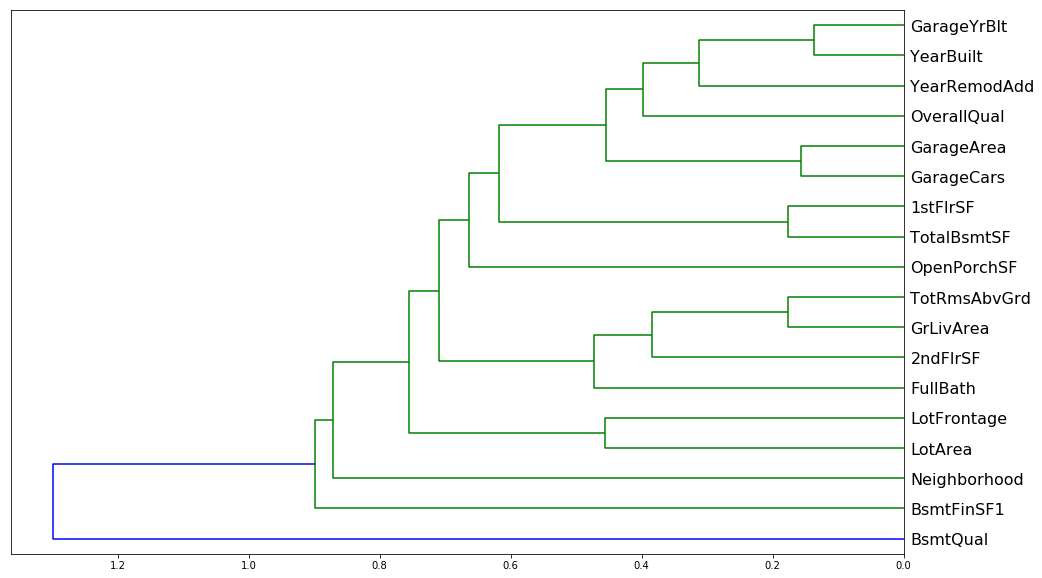

In [45]:
corr = np.round(scipy.stats.spearmanr(trim_trn_df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr, checks=False)
# corr_condensed[~np.isfinite(corr_condensed)] = 0
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=trim_trn_df.columns, orientation='left', leaf_font_size=16)
plt.show()

### Partial dependence ###

In [46]:
from pdpbox import pdp
from plotnine import *

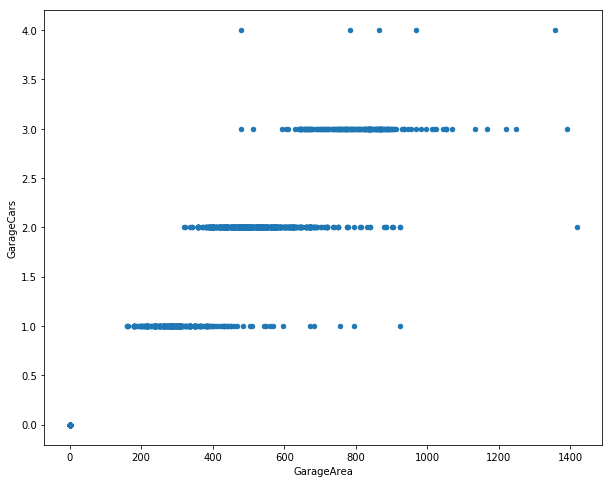

In [47]:
df_raw.plot('GarageArea', 'GarageCars', 'scatter', alpha=1.00, figsize=(10,8));

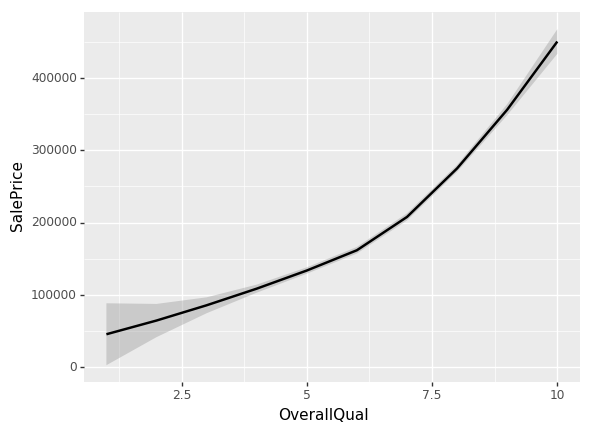

<ggplot: (327184339)>

In [48]:
ggplot(df_raw, aes('OverallQual', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [49]:
['GarageCars_na'] in trn_df2.columns.values

False

In [50]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m_oh, trn_df2, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

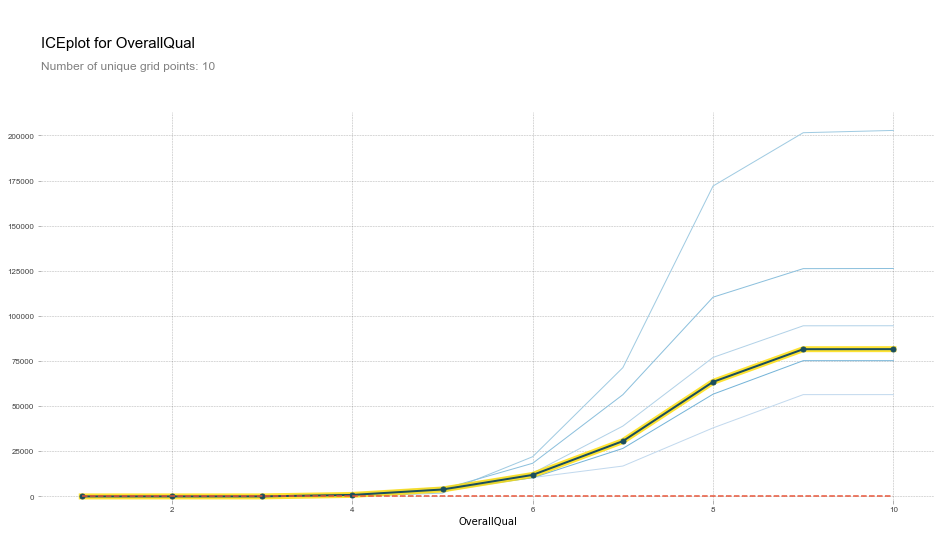

In [51]:
plot_pdp('OverallQual', clusters=5)

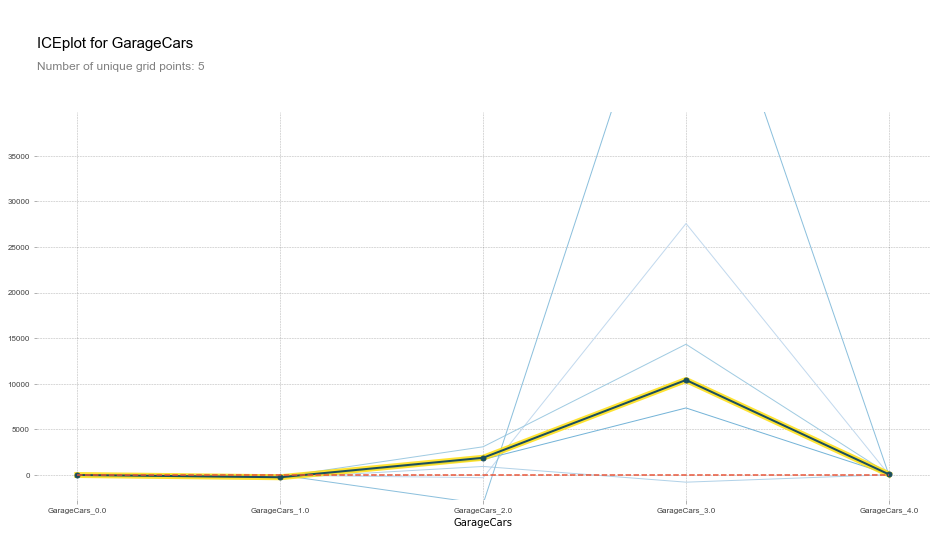

In [52]:
plot_pdp(['GarageCars_0.0', 'GarageCars_1.0', 'GarageCars_2.0', 'GarageCars_3.0', 'GarageCars_4.0'], 5, 'GarageCars')

In [53]:
trn_df.GarageCars.sort_values(ascending=False)

Id
748     5
1351    5
421     5
1191    5
478     4
1314    4
162     4
1159    4
168     4
1319    4
1317    4
546     4
1167    4
914     4
919     4
179     4
1170    4
1304    4
1303    4
186     4
927     4
684     4
701     4
904     4
1325    4
390     4
1355    4
1354    4
525     4
725     4
       ..
156     1
1327    1
1326    1
1324    1
496     1
166     1
1012    1
1124    1
1408    1
435     1
922     1
242     1
387     1
943     1
394     1
955     1
961     1
639     1
636     1
89      1
969     1
971     1
1138    1
977     1
614     1
109     1
211     1
432     1
583     1
1144    1
Name: GarageCars, Length: 1168, dtype: int8

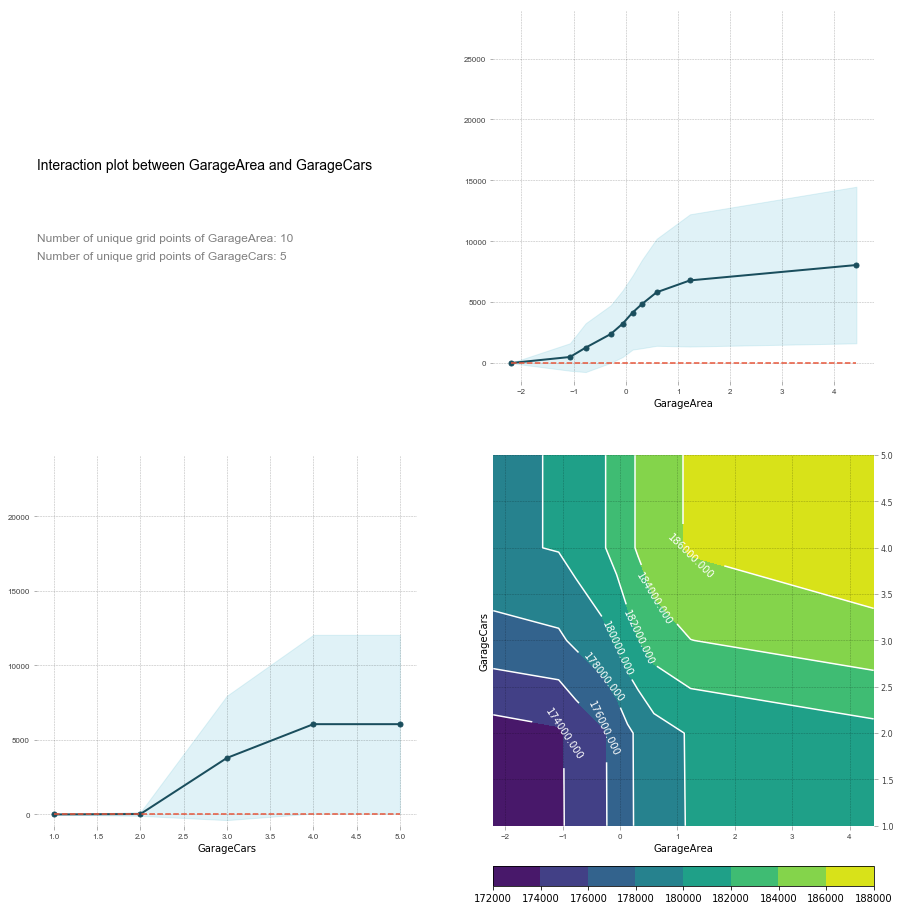

In [54]:
feats = ['GarageArea', 'GarageCars']
p = pdp.pdp_interact(m, trn_df, feats)
pdp.pdp_interact_plot(p, feats)

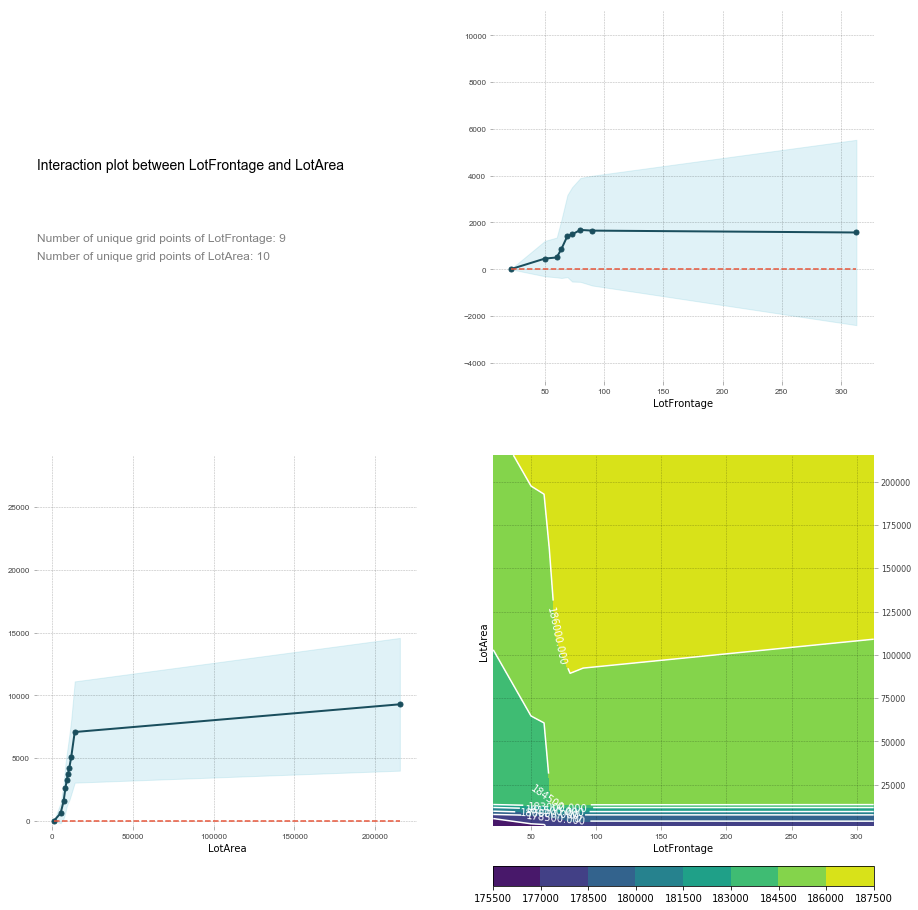

In [55]:
feats = ['LotFrontage', 'LotArea']
p = pdp.pdp_interact(m_oh, trn_df2, feats)
pdp.pdp_interact_plot(p, feats)

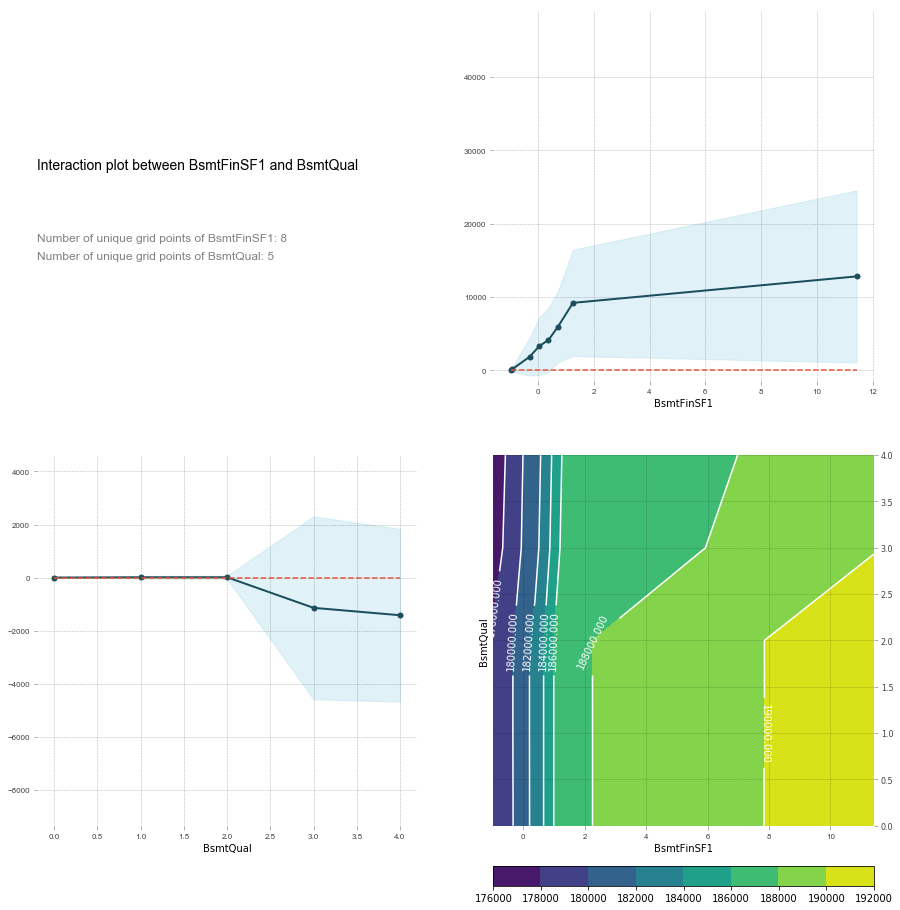

In [56]:
feats = ['BsmtFinSF1', 'BsmtQual']
p = pdp.pdp_interact(m, trn_df, feats)
pdp.pdp_interact_plot(p, feats)

#### Both feature importance trimming and one hot encoding ####

In [57]:
df_sep2, y2, nas = proc_df(df[list(trim_cols.keys()) + ['SalePrice']], 'SalePrice', max_n_cat=10)
((val_df2, trn_df2), (val_y2, trn_y2), (val_df_raw2, trn_df_raw2)) = split_by_idx(val_idx, df_sep2, y2, df)
m_oh = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, max_features=0.6, n_jobs=-1, oob_score=True)
m_oh.fit(trn_df2, trn_y2)
m_oh.score(val_df2, val_y2)

0.8892975505744157

In [58]:
np.sqrt(((np.log(m_oh.predict(val_df2))-np.log(val_y2))**2).sum()/len(val_y2))

0.16016954451189933